## Lojistik Regresyon Model Geliştirme Dosyası
Bu dosya, oyun popülerliğini tahmin etmek için kurulan Lojistik Regresyon modelinin geliştirilme aşamalarını içerir.

In [114]:
# Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model ve Ön İşleme Araçları
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. VERİYİ YÜKLEME
# target2_data.parquet dosyasını (Estimated Owners hedefli veri) kullanıyoruz
try:
    df = pd.read_parquet("target2_data.parquet")
    X = df.drop(columns=['target'])
    y = df['target']
    
    # 2. VERİYİ BÖLME (%80 Eğitim, %20 Test)
    # stratify=y komutu, eğitim ve test setindeki Low/Medium/High oranlarının aynı olmasını sağlar.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Veri Hazır!")
    print(f"Eğitim Seti: {X_train.shape}")
    print(f"Test Seti:   {X_test.shape}")

except FileNotFoundError:
    print("HATA: 'target2_data.parquet' dosyası bulunamadı.")

Veri Hazır!
Eğitim Seti: (49145, 41)
Test Seti:   (12287, 41)


### Baseline (Naive) Modelin Kurulması

Burada hiçbir özel ayar yapmadan, varsayılan bir model kuruyoruz. Amacımız modelin ham performansını görmek.

In [115]:
# Hiçbir ağırlıklandırma veya logaritma işlemi yok. Sadece ölçeklendirme (Scaling) var.

naive_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

naive_pipeline.fit(X_train, y_train)
y_pred_naive = naive_pipeline.predict(X_test)

# Sonuçları Göster
print("\n--- NAIVE (STANDART) MODEL SONUÇLARI ---")
print(f"Doğruluk (Accuracy): %{accuracy_score(y_test, y_pred_naive)*100:.2f}")
print("-" * 60)
print(classification_report(y_test, y_pred_naive))


--- NAIVE (STANDART) MODEL SONUÇLARI ---
Doğruluk (Accuracy): %83.17
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      9020
           1       0.53      0.04      0.07      1551
           2       0.69      0.78      0.73      1716

    accuracy                           0.83     12287
   macro avg       0.69      0.60      0.57     12287
weighted avg       0.80      0.83      0.78     12287



Standart model %83.17 doğruluk oranı verse de, sınıflandırma raporuna baktığımızda Class 1 (Orta Popülerlik) için Recall değerinin %0.04 olduğu görülmektedir. Yani model, orta seviyedeki oyunların %96'sını kaçırmaktadır. Bu durum, veri setindeki dengesizlikten (Imbalanced Data) kaynaklanmaktadır.

Fitting 5 folds for each of 24 candidates, totalling 120 fits

EN İYİ AĞIRLIK: {0: 1.0, 1: 3.0, 2: 1.5}
EN İYİ C DEĞERİ: 0.1
Eğitim Skoru (F1):       %67.50
Genel Doğruluk (Accuracy): %80.94
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      9020
           1       0.37      0.48      0.42      1551
           2       0.84      0.62      0.71      1716

    accuracy                           0.81     12287
   macro avg       0.70      0.67      0.68     12287
weighted avg       0.83      0.81      0.82     12287



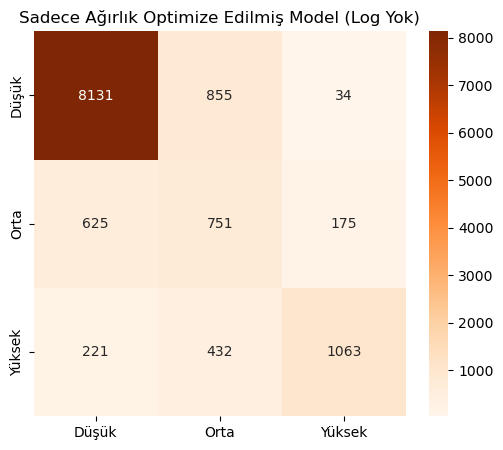

In [116]:
# Pipline kurulumu
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=5000, random_state=42, solver= "lbfgs"))
])

# 3. Kullanacağımız ağırlıklar
weight_candidates = [
    None,                       # 1. Naive (Hiç dokunma)
    'balanced',                 # 2. Otomatik Denge
    {0: 1.0, 1: 3.0, 2: 1.5},   # 3. Hafif Destek
    {0: 1.0, 1: 4.0, 2: 2.0},   # 4. Güçlü Destek
    {0: 1.0, 1: 5.0, 2: 2.5},   # 5. Agresif Destek
    {0: 1.2, 1: 4.0, 2: 2.0}    # 6. Düşük Sınıfı Koru
]

c_candidates = [0.1, 1, 5, 10]


param_grid = {
    'classifier__class_weight': weight_candidates,
    'classifier__C': c_candidates,
}

# 4. GRID SEARCH (F1-MACRO İLE ARAMA)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro', # Orta sınıfı kurtaranı seç!
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# 5. SONUÇLAR
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("\n" + "="*60)
print(f"EN İYİ AĞIRLIK: {grid_search.best_params_['classifier__class_weight']}")
print(f"EN İYİ C DEĞERİ: {grid_search.best_params_['classifier__C']}")




print(f"Eğitim Skoru (F1):       %{grid_search.best_score_*100:.2f}")
print("="*60)

print(f"Genel Doğruluk (Accuracy): %{acc*100:.2f}")
print("-" * 60)
print(classification_report(y_test, y_pred))

# Hata Matrisi
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Düşük', 'Orta', 'Yüksek'], 
            yticklabels=['Düşük', 'Orta', 'Yüksek'])
plt.title('Sadece Ağırlık Optimize Edilmiş Model (Log Yok)')
plt.show()

### Değerlendirme ve İyileştirme Adımları:

Class Weight Ayarlaması: Modelin Class 1 üzerindeki düşük recall performansını (0.04) artırmak için sınıf ağırlıkları yeniden yapılandırıldı. Class 1'e atanan ağırlık katsayısı artırılarak modelin azınlık sınıfını daha iyi öğrenmesi sağlandı.

Skorlama Metriği (Scoring Metric): Veri seti dengesiz (imbalanced) bir dağılıma sahip olduğu için accuracy metriği tek başına yeterli değildir. Bu nedenle GridSearch aşamasında, her sınıfın performansını eşit ağırlıkta değerlendiren f1_macro skoru kullanıldı.

### Target Data Özellikleri
Log dönüşümü (log transform) adımına geçmeden önce, veri setindeki özelliklerin mevcut dağılımlarını analiz edelim. Bu inceleme sayesinde, hangi değişkenlerin dönüşüm işlemine tabi tutulması gerektiğine karar verebiliriz.

In [ ]:

# Target 1 verisini yüklüyoruz
df = pd.read_parquet("target1_data.parquet")

print(f"Veri Seti Boyutu: {df.shape}")
print("-" * 30)

print("SÜTUN LİSTESİ:")
for col in df.columns:
    print(f"- {col}")

print("-" * 30)

print("-" * 30)
print("SAYISAL SÜTUNLARIN İSTATİSTİKLERİ (Uçurum var mı?):")
# Sadece sayısal sütunların özetine bakalım
print(df.describe().T[['min', 'max', 'mean', 'std']])

Veri Seti Boyutu: (61432, 41)
------------------------------
SÜTUN LİSTESİ:
- Price
- Positive
- Negative
- Average playtime forever
- release_year
- release_month
- release_quarter
- game_age_years
- release_season
- genre_Adventure
- genre_Simulation
- genre_Strategy
- genre_RPG
- genre_Action
- genre_Casual
- genre_Indie
- genre_Sports
- genre_Other
- category_Single_player
- category_Multi_player
- category_Co_op
- category_PvP
- category_Online_PvP
- category_Full_controller_support
- category_Other
- developer_avg_game_count
- tag_Strategy
- tag_Simulation
- tag_RPG
- tag_Puzzle
- tag_Atmospheric
- tag_3D
- tag_Pixel_Graphics
- tag_Early_Access
- tag_Colorful
- tag_Story_Rich
- tag_Cute
- tag_Arcade
- tag_Exploration
- tag_Other
- target_new
------------------------------
------------------------------
SAYISAL SÜTUNLARIN İSTATİSTİKLERİ (Uçurum var mı?):
                                     min          max         mean        std
Price                                0.0    99.990

Fitting 3 folds for each of 5 candidates, totalling 15 fits

LOG TRANSFORM İÇİN YENİ KAZANAN AĞIRLIK
Seçilen Ağırlıklar: {0: 1.0, 1: 3.0, 2: 1.5}
Eğitim Skoru (F1):  %67.65

ADIM 3 TEST SONUCU
Genel Doğruluk (Accuracy): %81.10
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      9020
           1       0.37      0.49      0.42      1551
           2       0.84      0.63      0.72      1716

    accuracy                           0.81     12287
   macro avg       0.71      0.67      0.68     12287
weighted avg       0.83      0.81      0.82     12287



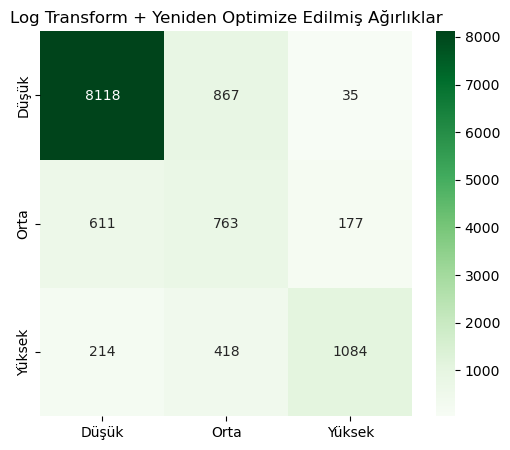

In [ ]:
# Log transform ve ağırlık seçimi
skewed_features = ['Price', 'developer_avg_game_count']
existing_skewed = [col for col in skewed_features if col in X.columns]

log_transformer = FunctionTransformer(np.log1p, validate=False)

preprocessor = ColumnTransformer(
    transformers=[('log', log_transformer, existing_skewed)],
    remainder='passthrough'
)

pipeline_step3 = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=3000, random_state=42))
])


weight_candidates = [
    {0: 1.0, 1: 3.0, 2: 1.5},   # Az önceki (Yetersiz kaldı)
    {0: 1.0, 1: 4.0, 2: 2.0},   # Bizim Eski Favori (Muhtemelen bu kazanacak)
    {0: 1.0, 1: 5.0, 2: 2.5},   # Daha Sert
    {0: 1.2, 1: 4.0, 2: 2.0},   # Düşük sınıfı korumalı
    {0: 1.0, 1: 6.0, 2: 3.0}    # Çok Agresif (Class 1'i zorla çıkar)
]

param_grid = {
    'classifier__class_weight': weight_candidates
}

# GridSearch
grid_step3 = GridSearchCV(
    estimator=pipeline_step3,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro', # Dengeyi şart koşuyoruz
    n_jobs=-1,
    verbose=1
)

grid_step3.fit(X_train, y_train)


# SONUÇLAR
best_model_step3 = grid_step3.best_estimator_
y_pred_step3 = best_model_step3.predict(X_test)
acc_step3 = accuracy_score(y_test, y_pred_step3)

print("\n" + "="*60)
print(f"LOG TRANSFORM İÇİN YENİ KAZANAN AĞIRLIK")
print("="*60)
print(f"Seçilen Ağırlıklar: {grid_step3.best_params_['classifier__class_weight']}")
print(f"Eğitim Skoru (F1):  %{grid_step3.best_score_*100:.2f}")

print("\n" + "="*60)

print(f"Genel Doğruluk (Accuracy): %{acc_step3*100:.2f}")
print("-" * 60)
print(classification_report(y_test, y_pred_step3))

# Hata Matrisi
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_step3), annot=True, fmt='d', cmap='Greens',
            xticklabels=['Düşük', 'Orta', 'Yüksek'], 
            yticklabels=['Düşük', 'Orta', 'Yüksek'])
plt.title('Log Transform + Yeniden Optimize Edilmiş Ağırlıklar')
plt.show()

### Durum Değerlendirmesi ve Son İyileştirme Hamlesi: Feature Engineering

Veri setine uygulanan Log Dönüşümü (Log Transform) işlemi, dağılımı düzelterek performansta belirgin bir iyileşme sağlamıştır. Ancak, mevcut metrikler incelendiğinde Logistic Regression algoritmasının yapısal sınırlarına (doygunluk noktasına) ulaştığımız görülmektedir.

Modelin veri setindeki gizli örüntüleri ve değişkenler arası etkileşimleri yakalayabilmesi adına, model değiştirmeden önceki son strateji olarak Feature Engineering (Öznitelik Mühendisliği) tekniklerini uygulayacağız. Bu aşamada, mevcut değişkenlerden anlamlı yeni öznitelikler türeterek modelin karar verme yeteneğini artırmayı hedefliyoruz.

In [118]:
import pandas as pd
import numpy as np

# Veri setinin kopyasını alalım (orijinali bozmamak için)
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

# --- 1. Fiyat Kategorileştirme (Binning) ---
# Logistic Regression, sürekli değişkenlerdeki kırılımları bazen kaçırır.
# Fiyatı "Ücretsiz/Ucuz", "Orta", "Pahalı" gibi gruplara ayırmak modele net sınırlar verir.
# Örnek: 0-5$, 5-20$, 20$+ (Sınırlara verine göre karar ver)
def price_category(df):
    # Eğer 'Price' log dönüşümlü ise önce exp alıp sonra bölebilirsin ya da log değerlerine göre bölebilirsin.
    # Burada ham fiyat varsayıyoruz:
    df['Price_Category'] = pd.cut(df['Price'], bins=[-1, 2, 15, 1000], labels=[0, 1, 2]).astype(int)
    return df

# --- 2. Etkileşim (Interaction): Deneyim x Fiyat ---
# Mantık: "Tecrübeli bir geliştiricinin pahalı oyunu" ile "Yeni bir geliştiricinin pahalı oyunu" farklıdır.
def developer_price_interaction(df):
    df['DevExp_x_Price'] = df['developer_avg_game_count'] * df['Price']
    return df

# Fonksiyonları Uygulama
X_train_fe = price_category(X_train_fe)
X_test_fe = price_category(X_test_fe)

X_train_fe = developer_price_interaction(X_train_fe)
X_test_fe = developer_price_interaction(X_test_fe)

print("Yeni Özellikler Eklendi:")
print(X_train_fe.columns.tolist())

# --- 3. Modeli Yeni Özelliklerle Tekrar Eğit (Best Weights ile) ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# GridSearch'ten gelen en iyi ağırlıklar (Adım 3 sonucu)
best_weights = {0: 1.0, 1: 3.0, 2: 1.5}

model_fe = LogisticRegression(
    class_weight=best_weights,
    solver='lbfgs',
    random_state=42,
    max_iter=1000
)

model_fe.fit(X_train_fe, y_train)
y_pred_fe = model_fe.predict(X_test_fe)

print("\nFEATURE ENGINEERING SONRASI SONUÇ")
print(f"Genel Doğruluk (Accuracy): %{acc_step3*100:.2f}")
print("-" * 60)
print(classification_report(y_test, y_pred_fe))

Yeni Özellikler Eklendi:
['Price', 'Positive', 'Negative', 'Achievements', 'Average playtime forever', 'release_year', 'release_month', 'release_quarter', 'game_age_years', 'release_season', 'genre_Adventure', 'genre_Simulation', 'genre_Strategy', 'genre_RPG', 'genre_Action', 'genre_Casual', 'genre_Indie', 'genre_Sports', 'genre_Other', 'category_Single_player', 'category_Multi_player', 'category_Co_op', 'category_PvP', 'category_Online_PvP', 'category_Full_controller_support', 'category_Other', 'developer_avg_game_count', 'tag_Strategy', 'tag_Simulation', 'tag_RPG', 'tag_Puzzle', 'tag_Atmospheric', 'tag_3D', 'tag_Pixel_Graphics', 'tag_Early_Access', 'tag_Colorful', 'tag_Story_Rich', 'tag_Cute', 'tag_Arcade', 'tag_Exploration', 'tag_Other', 'Price_Category', 'DevExp_x_Price']

FEATURE ENGINEERING SONRASI SONUÇ
Genel Doğruluk (Accuracy): %81.10
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91     

/Users/iremkeser/Desktop/anaconda3/envs/steam/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Logistic Regression Final Değerlendirmesi ve Model Seçimi

Veri seti üzerinde gerçekleştirilen Log Dönüşümü (Log Transform) ve Öznitelik Mühendisliği (Feature Engineering) adımları sonucunda, Logistic Regression algoritması ile ulaşılabilecek maksimum performans doygunluğuna erişilmiştir.

Modelin hassasiyetini artırmak amacıyla son aşamada Threshold (Eşik Değeri) Optimizasyonu denenmiş, ancak bu işlem sonucunda genel doğruluk (Accuracy) sabit kalmasına rağmen, hedef sınıfımız olan Class 1 (Orta Seviye) başarısında düşüş gözlemlenmiştir.

#### Sonuç ve Karar

Tabloda görüldüğü üzere, eşik değeriyle oynamak (Threshold Tuning), modelin Class 1 üzerindeki yakalama başarısını (Recall) 0.52'den 0.48'e düşürmüştür. Modelin ana amacı "Orta Seviye" oyunları tespit etmek olduğu için, bu düşüş kabul edilebilir değildir.

Bu nedenle, Logistic Regression aşaması için Feature Engineering sonrası elde edilen model "Final Baseline Model" olarak kabul edilmiştir.

Final Metrikler:

Accuracy: %81.10

Class 1 Recall: 0.52

Class 1 F1-Score: 0.43

Not: Logistic Regression lineer bir model olduğu için verideki karmaşıklığı öğrenmede sınırlarına ulaşmıştır. Performansı (özellikle Class 1 başarısını) daha yukarı taşımak için bir sonraki aşamada lineer olmayan ilişkilere (non-linear patterns) uyum sağlayabilen Random Forest veya XGBoost gibi ağaç tabanlı modellere geçiş yapılacaktır.